# Libraries

In [2]:
import cobra as cb
import logging
logging.basicConfig(filename="log.txt"  , level=logging.INFO)
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy
from statsmodels.distributions.empirical_distribution import ECDF
from distfit import distfit
import matplotlib.pyplot as plt
import seaborn as sns

# Set up

In [3]:
modelNames = ["ENGRO 1", "ENGRO 2"]

In [4]:
##############################################
# Create a folder if it doesn't already exist
# Parameters
# - path --> new folder path
##############################################
def createFolder(path):
    if not os.path.exists(path):
            os.mkdir(path)

# Loading models

In [5]:
##############################################
# Load the models files (.xml)
# Parameters
# - modelNames --> list of models names that must
# match the file names
# - modelFolder --> the folder containing the 
# models files
##############################################
def loadModels(modelNames, modelFolder):
    models = {}
    for modelName in modelNames:
        files = os.listdir(modelFolder)
        found = False
        for file in files:
            filename, extension = os.path.splitext(file)
            if(filename == modelName):
                found = True
                break
        if(found):
            if(extension == ".xml"):
                models[modelName] = cb.io.read_sbml_model(modelFolder + filename + extension)
            else:
                raise ImportError('Model file extension not supported')
        else:
            raise FileNotFoundError('File not found')
    return models

In [6]:
modelsDict = loadModels(modelNames, "../../models/")
modelReactionsDict = {}
for modelName in modelNames:
    listReactions = []
    for reaction in modelsDict[modelName].reactions:
        listReactions.append(reaction.id)
    modelReactionsDict[modelName] = listReactions

[distfit] >INFO> The current solver interface glpk doesn't support setting the optimality tolerance.
[distfit] >INFO> The current solver interface glpk doesn't support setting the optimality tolerance.


# Figure 1: FDR vs thinning

In [9]:
fdrPath = "../../results/FDR/ENGRO 1/mannwhitney/analysis/adjusted/"

fileName =  "chrrThinning1.csv" 
df1 = pd.read_csv(fdrPath + fileName)
df1["Thinning"] = 1
df1 = df1[df1["Samples"] == 1000]

fileName =  "chrrThinning5.csv" 
df5 = pd.read_csv(fdrPath + fileName)
df5["Thinning"] = 5
df5 = df5[df5["Samples"] == 1000]

fileName =  "chrrThinning10.csv" 
df10 = pd.read_csv(fdrPath + fileName)
df10["Thinning"] = 10
df10 = df10[df10["Samples"] == 1000]

fileName =  "chrrThinning30.csv" 
df30 = pd.read_csv(fdrPath + fileName)
df30["Thinning"] = 30
df30 = df30[df30["Samples"] == 1000]

dfENGRO1 = pd.concat([df1,  df5, df10, df30], ignore_index=True)

df2ENGRO1 = pd.read_csv(fdrPath + "chrrThinning1.csv")
df2ENGRO1 = df2ENGRO1[df2ENGRO1["Samples"].isin( [1000, 5000, 10000, 30000])]

In [10]:
fdrPath = "../../results/FDR/ENGRO 2/mannwhitney/analysis/adjusted/"

fileName =  "chrrThinning1.csv" 
df1 = pd.read_csv(fdrPath + fileName)
df1["Thinning"] = 1
df1 = df1[df1["Samples"] == 1000]

fileName =  "chrrThinning5.csv" 
df5 = pd.read_csv(fdrPath + fileName)
df5["Thinning"] = 5
df5 = df5[df5["Samples"] == 1000]

fileName =  "chrrThinning10.csv" 
df10 = pd.read_csv(fdrPath + fileName)
df10["Thinning"] = 10
df10 = df10[df10["Samples"] == 1000]

fileName =  "chrrThinning30.csv" 
df30 = pd.read_csv(fdrPath + fileName)
df30["Thinning"] = 30
df30 = df30[df30["Samples"] == 1000]

dfENGRO2 = pd.concat([df1,  df5, df10, df30], ignore_index=True)

df2ENGRO2 = pd.read_csv(fdrPath + "chrrThinning1.csv")
df2ENGRO2 = df2ENGRO2[df2ENGRO2["Samples"].isin( [1000, 5000, 10000, 30000])]

In [11]:
dfENGRO1["std"]=dfENGRO1.iloc[:,1:-2].T.std().values
df2ENGRO1["std"]=df2ENGRO1.iloc[:,1:-2].T.std().values
dfENGRO1["Samples"]=df2ENGRO1["Samples"].values

dfENGRO2["std"]=dfENGRO2.iloc[:,1:-2].T.std().values
df2ENGRO2["std"]=df2ENGRO2.iloc[:,1:-2].T.std().values
dfENGRO2["Samples"]=df2ENGRO2["Samples"].values

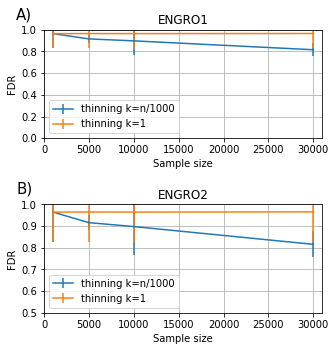

In [13]:
fig,ax=plt.subplots(2,1)
fig.set_size_inches(w=4.7747, h=5)
ax[0].errorbar(data=dfENGRO1,x="Samples",y="Total", yerr="std",label="thinning k=n/1000")
ax[0].errorbar(data=df2ENGRO1,x="Samples",y="Total", yerr="std",label="thinning k=1")
ax[0].grid()
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,31000])
ax[0].set_ylabel("FDR")
ax[0].set_xlabel("Sample size")
ax[0].set_title("ENGRO1")
ax[0].legend()


ax[1].errorbar(data=dfENGRO2,x="Samples",y="Total", yerr="std",label="thinning k=n/1000")
ax[1].errorbar(data=df2ENGRO2,x="Samples",y="Total", yerr="std",label="thinning k=1")
ax[1].grid()
ax[1].set_ylim([0.5,1])
ax[1].set_xlim([0,31000])
ax[1].set_ylabel("FDR")
ax[1].set_xlabel("Sample size")

ax[1].set_title("ENGRO2")
ax[1].legend()

ax[0].text(-0.1, 1.1, 'A)',fontdict={"fontsize":15},transform=ax[0].transAxes)
ax[1].text(-0.1, 1.1, 'B)',fontdict={"fontsize":15},transform=ax[1].transAxes)
plt.tight_layout()

fig.savefig("../../figures/figure1_thinning_effect.png",dpi=600)

# Figure 2: Diagnostic

In [26]:
#%% data foldchange
#engro1
df1=pd.read_csv("../../results/FDR/ENGRO 1/mannwhitney/analysis/adjustedFoldChange/chrrThinning1.csv",index_col=0)
df1=pd.DataFrame(df1.mean(1)).reset_index()

#engro2
df2=pd.read_csv("../../results/FDR/ENGRO 2/mannwhitney/analysis/adjustedFoldChange/chrrThinning1.csv",index_col=0)
df2=pd.DataFrame(df2.mean(1)).reset_index()

#%% data geweke engro1
thres=1.28
dfs_geweke=[]
for i in range(20):
    df=pd.read_csv("../../results/convergence/ENGRO 1/geweke/CHRRThinning100_1000_"+str(i)+".csv",index_col=0)
    df.columns=["reactions",str(i)]
    dfs_geweke.append(df.iloc[:,1])
dfs_geweke=pd.concat(dfs_geweke,axis=1)
dfs_geweke.index=df["reactions"].values

dfMW=pd.read_csv("../../results/FDR/ENGRO 1/mannwhitney/analysis/adjusted/chrrThinning100.csv",index_col=0).loc[1000]

dfCompare=pd.DataFrame(index=df["reactions"].values,columns=["MW","Geweke"])
dfCompare["Geweke"]=(dfs_geweke.abs()>thres).mean(1)
dfCompare["MW"]=dfMW.iloc[0:-1]
#%%  dati geweke engro2

dfs_geweke=[]
for i in range(20):
    df=pd.read_csv("../../results/convergence/ENGRO 2/geweke/CHRRThinning100_1000_"+str(i)+".csv",index_col=0)
    df.columns=["reactions",str(i)]
    dfs_geweke.append(df.iloc[:,1])
dfs_geweke=pd.concat(dfs_geweke,axis=1)
dfs_geweke.index=df["reactions"].values

dfMW=pd.read_csv("../../results/FDR/ENGRO 2/mannwhitney/analysis/adjusted/chrrThinning100.csv",index_col=0).loc[1000]


In [27]:
dfCompare2=pd.DataFrame(index=df["reactions"].values,columns=["MW","Geweke"])
dfCompare2["Geweke"]=(dfs_geweke.abs()>thres).mean(1)
dfCompare2["MW"]=dfMW.iloc[0:-1]
dfCompare2=dfCompare2.dropna()
dfCompare2=dfCompare2[dfCompare2["MW"]>0]

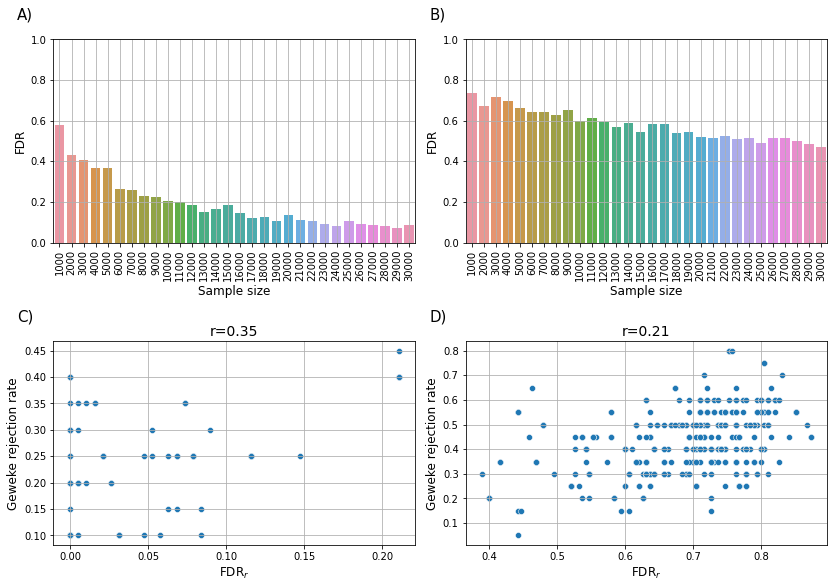

In [28]:

#%%
fig,ax=plt.subplots(2,2,layout="constrained")
fig.set_size_inches(11.69,8.27)

j=0
sns.barplot(data=df1,x="Samples",y=0,ax=ax[j,0])
sns.barplot(data=df2,x="Samples",y=0,ax=ax[j,1])
titles=["ENGRO1","ENGRO2"]
limits=[[0,1],[0,1]]
for i in range(2):
    ax[j,i].set_ylim(limits[i])
    #ax[i].set_xlim([-0.5,9.5])
    ax[j,i].set_ylabel("FDR",fontsize = 12.0)
    ax[j,i].set_xlabel("Sample size",fontsize = 12.0)
    ax[j,i].tick_params(axis="x", rotation=90,labelsize=10)
    ax[j,i].grid()
    #ax[j,i].set_title(titles[i])
j=1
sns.scatterplot(data=dfCompare,y="Geweke",x="MW",ax=ax[j,0])
sns.scatterplot(data=dfCompare2,y="Geweke",x="MW",ax=ax[j,1])

limits=[[0,1],[0,1]]
values=[str(np.round(scipy.stats.spearmanr(dfCompare["MW"],dfCompare["Geweke"]).correlation,2)),
        str(np.round(scipy.stats.spearmanr(dfCompare2["MW"],dfCompare2["Geweke"]).correlation,2))]
for i in range(2):
 #   ax[j,i].set_ylim(limits[i])
    #ax[i].set_xlim([-0.5,9.5])
    ax[j,i].set_xlabel("FDR$_{r}$",fontsize = 12.0)
    ax[j,i].set_ylabel("Geweke rejection rate",fontsize = 12.0)
    ax[j,i].grid()
    ax[j,i].set_title("r="+values[i],fontsize = 14)
    
    
## inserisco le figure
ax[0,0].text(-0.1, 1.1, 'A)',fontdict={"fontsize":15},transform=ax[0,0].transAxes)
ax[0,1].text(-0.1, 1.1, 'B)',fontdict={"fontsize":15},transform=ax[0,1].transAxes)
ax[1,0].text(-0.1, 1.1,'C)',ha='left',fontdict={"fontsize":15},transform=ax[1,0].transAxes)
ax[1,1].text(-0.1, 1.1, 'D)',fontdict={"fontsize":15},transform=ax[1,1].transAxes)

plt.tight_layout()
fig.savefig("../../figures/Figure2_PanelDiagnostic.png",dpi=600)

# Figure 3: Kl test

In [42]:
howmanys=[]
howmanys2=[]
sample_size=[]
thinnings=[]
reactions_name=[]
algorithms=[]
thres=150
howmanys2=[]
for algorithm in ["chrr"]:
    for thinning in [1,10,100]:
        
        df=pd.read_csv("../../results/KLD/ENGRO 1/" + algorithm + "Thinning" +str(thinning) + "/kld.csv",index_col=0)

        
        reactions=df.columns[1:]
        #
        df["sample"]=df["pair"].apply(lambda x:x.split("_")[0])
        df["a"]=df["pair"].apply(lambda x:x.split("_")[1])
        df["b"]=df["pair"].apply(lambda x:x.split("_")[4])
        df["a_b"]=df["pair"].apply(lambda x:x.split("_")[1]+"_"+x.split("_")[4])
        #
    
        for sample in [1000,5000,10000,30000]:
            
            for reaction in reactions:
                df2=df[["pair",reaction,"sample","a","b"]]
                df2=df2[df2["sample"]==str(sample)]
                df3tr=df2.iloc[:thres,:]
                df3te=df2.iloc[thres:,:]

                
                ecdf=ECDF(df3tr[reaction].values)
                values=ecdf(df3te[reaction].values)
                
                howmany=np.sum(values>0.99)
                
                #print(reaction,howmany)
                howmanys.append(howmany)

                sample_size.append(sample)
                reactions_name.append(reaction)
                thinnings.append(thinning)
                algorithms.append(algorithm)

                
 #%%
dfRes=pd.DataFrame(columns=["reaction_name","FDR","sample"])
dfRes["FDR"]=np.array(howmanys)/(190-thres)

dfRes["sample"]=sample_size
dfRes["Thinning"]=thinnings
dfRes["reaction_name"]=reactions_name
dfRes["algorithm"]=algorithms

In [43]:
howmanys=[]
howmanys2=[]
sample_size=[]
thinnings=[]
reactions_name=[]
algorithms=[]
thres=150
howmanys2=[]
for algorithm in ["chrr"]:
    for thinning in [1,10,100]:
        
        df=pd.read_csv("../../results/KLD/ENGRO 2/" + algorithm + "Thinning" +str(thinning) + "/kld.csv",index_col=0)

        reactions=df.columns[1:]
        #
        df["sample"]=df["pair"].apply(lambda x:x.split("_")[0])
        df["a"]=df["pair"].apply(lambda x:x.split("_")[1])
        df["b"]=df["pair"].apply(lambda x:x.split("_")[4])
        df["a_b"]=df["pair"].apply(lambda x:x.split("_")[1]+"_"+x.split("_")[4])
        #
    
        for sample in [1000,5000,10000,30000]:
            
            for reaction in reactions:
                df2=df[["pair",reaction,"sample","a","b"]]
                df2=df2[df2["sample"]==str(sample)]
                df3tr=df2.iloc[:thres,:]
                df3te=df2.iloc[thres:,:]

                
                ecdf=ECDF(df3tr[reaction].values)
                values=ecdf(df3te[reaction].values)
                
                howmany=np.sum(values>0.99)
                
                #print(reaction,howmany)
                howmanys.append(howmany)

                sample_size.append(sample)
                reactions_name.append(reaction)
                thinnings.append(thinning)
                algorithms.append(algorithm)

                
 #%%
dfRes2=pd.DataFrame(columns=["reaction_name","FDR","sample"])
dfRes2["FDR"]=np.array(howmanys)/(190-thres)

dfRes2["sample"]=sample_size
dfRes2["Thinning"]=thinnings
dfRes2["reaction_name"]=reactions_name
dfRes2["algorithm"]=algorithms

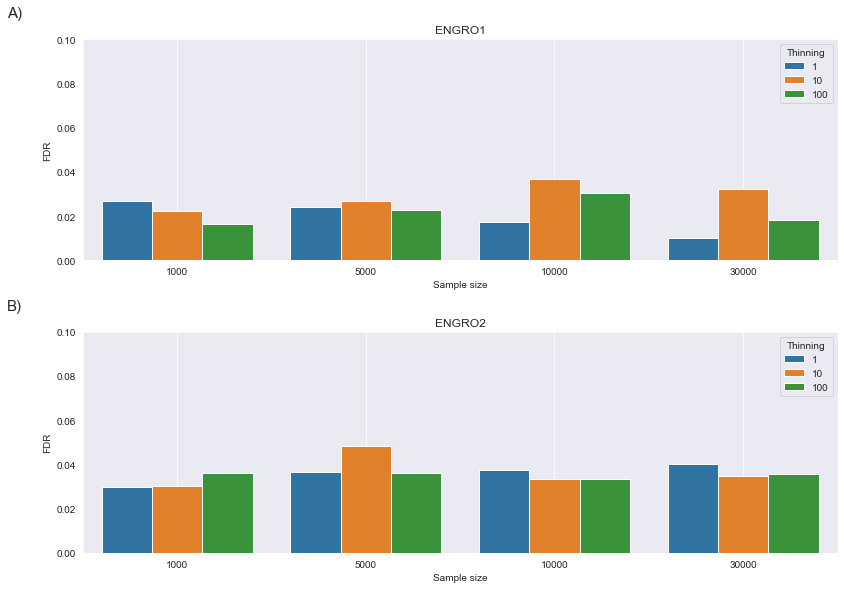

In [44]:
fig,ax=plt.subplots(2,1,layout="constrained")
fig.set_size_inches(11.69,8.27)

sns.set_style("darkgrid")
dfResA=dfRes[dfRes["algorithm"]==algorithm];
sns.barplot(data=dfResA,x="sample",y="FDR",hue="Thinning", ci=None,ax=ax[0]);
ax[0].set_ylim([0,0.1]);
ax[0].set_title("ENGRO1");
ax[0].grid();
ax[0].set_xlabel("Sample size")
ax[0].set_ylabel("FDR")


dfResA=dfRes2[dfRes2["algorithm"]==algorithm];
sns.barplot(data=dfResA,x="sample",y="FDR",hue="Thinning", ci=None,ax=ax[1]);
ax[1].set_ylim([0,0.1]);
ax[1].set_title("ENGRO2");
ax[1].grid();
ax[1].set_xlabel("Sample size")
ax[1].set_ylabel("FDR")
#ax[0].xticks(rotation='vertical');

ax[0].text(-0.1, 1.1,'A)',ha='left',fontdict={"fontsize":15},transform=ax[0].transAxes)
ax[1].text(-0.1, 1.1, 'B)',fontdict={"fontsize":15},transform=ax[1].transAxes)

plt.tight_layout()
plt.savefig("../../figures/KLD.png",dpi=600)

# Figure 5: CHRR

In [32]:
df1sENGRO1=[]
for i in range(20):
    df1ENGRO1=pd.read_csv("../../samples/ENGRO 1/CHRRThinning100/1000_"+str(i)+"_chrr.csv",index_col=0)
    df1sENGRO1.append(df1ENGRO1)
df1ENGRO1=pd.concat(df1sENGRO1)

In [33]:
df1sENGRO2=[]
for i in range(20):
    df1ENGRO2=pd.read_csv("../../samples/ENGRO 2/CHRRThinning100/1000_"+str(i)+"_chrr.csv",index_col=0)
    df1sENGRO2.append(df1ENGRO2)
df1ENGRO2=pd.concat(df1sENGRO2)

In [34]:
df2sENGRO1=[]
for i in range(20):
    df2ENGRO1=pd.read_csv("../../samples/ENGRO 1/CBS3groupedBy1000/"+str(i)+"_0.csv",index_col=0)
    df2sENGRO1.append(df2ENGRO1)
df2ENGRO1=pd.concat(df2sENGRO1)


In [35]:
df2sENGRO2=[]
for i in range(20):
    df2ENGRO2=pd.read_csv("../../samples/ENGRO 2/CBS3groupedBy1000/"+str(i)+"_0.csv",index_col=0)
    df2sENGRO2.append(df2ENGRO2)
df2ENGRO2=pd.concat(df2sENGRO2)

In [36]:
numcifre=6
df1sign2ENGRO1=df1ENGRO1.round(numcifre)>=0
df2sign2ENGRO1=df2ENGRO1.round(numcifre)>=0

df1sign2ENGRO2=df1ENGRO2.round(numcifre)>=0
df2sign2ENGRO2=df2ENGRO2.round(numcifre)>=0

In [46]:

howmanybENGRO1total=[]
howmany2bENGRO1total=[]

howmanybENGRO2total=[]
howmany2bENGRO2total=[]

range_search=range(10,1000,10)

for i in range_search:
    
    howmanybENGRO1=[]
    howmany2bENGRO1=[]
    howmanybENGRO2=[]
    howmany2bENGRO2=[]

    
    for j in range(20):
        
        howmanybENGRO1.append(df1sign2ENGRO1.iloc[j*1000:i+j*1000,:].drop_duplicates().shape[0])
        howmany2bENGRO1.append(df2sign2ENGRO1.iloc[j*1000:i+j*1000,:].drop_duplicates().shape[0])
        howmanybENGRO2.append(df1sign2ENGRO2.iloc[j*1000:i+j*1000,:].drop_duplicates().shape[0])
        howmany2bENGRO2.append(df2sign2ENGRO2.iloc[j*1000:i+j*1000,:].drop_duplicates().shape[0])
        
    howmanybENGRO1total.append(howmanybENGRO1)
    howmany2bENGRO1total.append(howmany2bENGRO1)
    
    howmanybENGRO2total.append(howmanybENGRO2)
    howmany2bENGRO2total.append(howmany2bENGRO2)

In [47]:
dfENGRO1mean=pd.read_csv("../../results/CHRR_CBS3/ENGRO 1/meanDiff.csv",index_col=0).T
dfENGRO1mean["mean"]=dfENGRO1mean.mean(1)
dfENGRO1mean=dfENGRO1mean.sort_values(by="mean",ascending=False).T
dfENGRO1mean=dfENGRO1mean.round(3).T.drop_duplicates().T
dfENGRO1mean

,aconitase,ATP_ADP,cit_synthase,P5CRxm,ORNTArm,ASRGL1,asparagine_synthetase,P5CRm,DM_PRPP,gln_synthetase,...,EX_Arg,ORNDC,SHMT1,ser_synthesis,fumarase,ARG1,PFK,Succ_dehydrogenase,RESP1,EX_O2
testName,,,,,,,,,,,,,,,,,,,,,
0.0,0.346,0.416,0.295,0.274,0.246,0.226,0.223,0.213,0.282,0.201,...,0.018,0.013,0.061,0.031,0.026,0.017,0.032,0.024,0.028,0.014
1.0,1.150,0.573,0.443,0.345,0.302,0.329,0.324,0.253,0.235,0.194,...,0.063,0.058,0.024,0.030,0.037,0.014,0.007,0.019,0.038,0.023
2.0,0.935,0.570,0.343,0.216,0.264,0.253,0.249,0.309,0.362,0.278,...,0.014,0.009,0.009,0.075,0.039,0.019,0.073,0.032,0.023,0.008
3.0,1.495,0.448,0.424,0.268,0.212,0.052,0.050,0.150,0.284,0.115,...,0.051,0.047,0.096,0.019,0.084,0.057,0.008,0.060,0.035,0.010
4.0,1.422,0.567,0.410,0.406,0.321,0.235,0.231,0.212,0.198,0.254,...,0.036,0.029,0.023,0.068,0.051,0.031,0.020,0.027,0.028,0.013
5.0,1.597,0.613,0.368,0.312,0.253,0.357,0.352,0.190,0.183,0.135,...,0.066,0.062,0.024,0.008,0.037,0.023,0.004,0.033,0.018,0.004
6.0,0.630,0.450,0.316,0.152,0.227,0.314,0.310,0.290,0.167,0.245,...,0.011,0.007,0.005,0.049,0.037,0.026,0.014,0.018,0.016,0.007
7.0,0.121,0.639,0.347,0.331,0.312,0.231,0.227,0.291,0.226,0.288,...,0.126,0.122,0.114,0.061,0.032,0.042,0.017,0.021,0.038,0.022
8.0,1.668,0.528,0.481,0.249,0.228,0.317,0.313,0.205,0.248,0.229,...,0.062,0.059,0.002,0.033,0.062,0.005,0.039,0.049,0.030,0.009


In [48]:
dfENGRO1var=pd.read_csv("../../results/CHRR_CBS3/ENGRO 1/varianceDiff.csv",index_col=0).T
dfENGRO1var["mean"]=dfENGRO1var.mean(1)

dfENGRO1var=dfENGRO1var.sort_values(by="mean",ascending=False).T
dfENGRO1var=dfENGRO1var.round(3).T.drop_duplicates().T
dfENGRO1var

,EX_Met,pyr_dehydrogenase,EX_O2,aconitase,RESP1,GATM,fumarase,ASS,RESP2,EX_THF,...,ARG1,glutamyltrasferase,GTHO,GTHP,ATP_ADP,DM_H2O2,aldolase,hexokinase,EX_Arg,ORNDC
testName,,,,,,,,,,,,,,,,,,,,,
0.0,0.929,0.916,0.935,0.912,0.925,0.922,0.918,0.917,0.911,0.918,...,0.789,0.777,0.768,0.776,0.792,0.760,0.741,0.716,0.661,0.661
1.0,0.934,0.926,0.902,0.923,0.899,0.912,0.908,0.908,0.905,0.910,...,0.780,0.776,0.777,0.769,0.755,0.759,0.741,0.722,0.669,0.668
2.0,0.911,0.925,0.922,0.919,0.915,0.910,0.915,0.915,0.914,0.907,...,0.785,0.793,0.780,0.772,0.754,0.756,0.738,0.710,0.659,0.658
3.0,0.932,0.928,0.921,0.917,0.915,0.922,0.908,0.903,0.907,0.917,...,0.778,0.788,0.776,0.771,0.784,0.752,0.740,0.695,0.661,0.660
4.0,0.925,0.928,0.911,0.920,0.906,0.911,0.901,0.901,0.903,0.910,...,0.781,0.780,0.774,0.771,0.764,0.763,0.735,0.705,0.660,0.660
5.0,0.927,0.929,0.936,0.921,0.925,0.909,0.920,0.917,0.917,0.907,...,0.799,0.799,0.776,0.768,0.730,0.747,0.743,0.729,0.660,0.661
6.0,0.932,0.916,0.933,0.913,0.922,0.911,0.913,0.912,0.913,0.909,...,0.785,0.773,0.775,0.768,0.814,0.751,0.738,0.722,0.661,0.661
7.0,0.930,0.923,0.900,0.913,0.897,0.916,0.914,0.914,0.908,0.910,...,0.798,0.773,0.777,0.778,0.716,0.771,0.736,0.726,0.655,0.655
8.0,0.927,0.928,0.918,0.919,0.913,0.907,0.911,0.910,0.909,0.907,...,0.787,0.790,0.773,0.757,0.786,0.741,0.743,0.725,0.666,0.666


In [49]:
dfENGRO2mean=pd.read_csv("../../results/CHRR_CBS3/ENGRO 2/meanDiff.csv",index_col=0).T
dfENGRO2mean["mean"]=dfENGRO2mean.mean(1)
dfENGRO2mean=dfENGRO2mean.sort_values(by="mean",ascending=False).T
dfENGRO2mean=dfENGRO2mean.round(3).T.drop_duplicates().T
dfENGRO2mean

,r0074,ILEtmi,ABUTH,ARGDr,ASNS1,r0465_1,UNK3,GHMT2r,EX_HC00576,r0283,...,HDCAt,EX_gluOUT__L_e,CSm,ASPte,r2526,PGI,CO2t,EX_h_e,ATPS4mi,EXRiboflavin
testName,,,,,,,,,,,,,,,,,,,,,
0.0,1.114,1.0,0.999,0.844,0.873,0.919,0.781,0.821,0.852,0.809,...,0.001,0.028,0.058,0.047,0.035,0.002,0.021,0.005,0.006,0.0
1.0,1.383,1.0,0.928,0.938,0.918,0.851,0.784,0.865,0.782,0.755,...,0.058,0.079,0.000,0.067,0.029,0.020,0.027,0.019,0.004,0.0
2.0,1.361,1.0,0.974,0.853,0.927,0.855,0.790,0.819,0.745,0.648,...,0.082,0.031,0.003,0.029,0.031,0.027,0.025,0.021,0.002,0.0
3.0,1.089,1.0,0.935,0.899,0.911,0.865,0.908,0.877,0.809,0.780,...,0.006,0.029,0.072,0.006,0.004,0.022,0.026,0.008,0.002,0.0
4.0,1.391,1.0,0.936,0.918,0.979,0.861,0.910,0.679,0.798,0.826,...,0.011,0.005,0.020,0.044,0.049,0.046,0.025,0.006,0.007,0.0
5.0,0.975,1.0,0.994,0.979,0.871,0.926,0.897,0.840,0.856,0.770,...,0.036,0.018,0.018,0.017,0.060,0.048,0.024,0.006,0.007,0.0
6.0,1.137,1.0,0.864,0.937,0.860,0.841,0.782,0.838,0.821,0.610,...,0.052,0.008,0.015,0.063,0.035,0.026,0.025,0.025,0.011,0.0
7.0,1.088,1.0,0.902,0.944,0.915,0.836,0.825,0.782,0.783,0.845,...,0.038,0.055,0.056,0.035,0.056,0.064,0.023,0.010,0.001,0.0
8.0,1.147,1.0,1.000,0.931,0.914,0.878,0.847,0.966,0.784,0.835,...,0.078,0.035,0.019,0.010,0.011,0.060,0.024,0.004,0.008,0.0


In [50]:
dfENGRO2var=pd.read_csv("../../results/CHRR_CBS3/ENGRO 2/varianceDiff.csv",index_col=0).T
dfENGRO2var["mean"]=dfENGRO2var.mean(1)
dfENGRO2var=dfENGRO2var.sort_values(by="mean",ascending=False).T
dfENGRO2var=dfENGRO2var.round(3).T.drop_duplicates().T
dfENGRO2var

,ILEtmi,MCAT,MACACI,HCO3E,ACITL,RNDR1,LEUtec,EX_pi_e,EX_phe__L_e,HMGCOAS,...,ExCystineGlu,HDCAt,DmPalm,EX_ptrcOUT_e,EX_ptrcIN_e,r0465_1,ABUTH,ARGDr,ASNS1,EX_ribflv_e
testName,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.974,0.978,0.974,0.974,0.976,0.975,0.975,0.974,0.972,...,0.709,0.656,0.657,0.612,0.609,0.339,0.999,0.684,0.535,0.0
1.0,1.0,0.979,0.974,0.979,0.978,0.972,0.972,0.971,0.970,0.964,...,0.658,0.667,0.666,0.615,0.621,0.702,0.306,0.014,0.457,0.0
2.0,1.0,0.979,0.976,0.979,0.979,0.970,0.970,0.970,0.967,0.971,...,0.626,0.665,0.666,0.627,0.624,0.683,0.364,0.758,0.109,0.0
3.0,1.0,0.972,0.977,0.972,0.972,0.972,0.972,0.972,0.970,0.972,...,0.543,0.667,0.667,0.637,0.615,0.650,0.445,0.596,0.337,0.0
4.0,1.0,0.968,0.974,0.968,0.968,0.973,0.972,0.972,0.970,0.968,...,0.686,0.664,0.664,0.607,0.600,0.694,0.404,0.545,0.892,0.0
5.0,1.0,0.975,0.975,0.975,0.975,0.975,0.975,0.974,0.972,0.970,...,0.608,0.660,0.661,0.628,0.633,0.188,0.957,0.870,0.774,0.0
6.0,1.0,0.976,0.976,0.976,0.976,0.973,0.972,0.972,0.971,0.971,...,0.730,0.671,0.671,0.622,0.614,0.742,0.727,0.088,0.672,0.0
7.0,1.0,0.971,0.974,0.971,0.971,0.970,0.971,0.969,0.968,0.966,...,0.705,0.651,0.651,0.639,0.638,0.717,0.752,0.320,0.394,0.0
8.0,1.0,0.983,0.976,0.983,0.983,0.971,0.970,0.970,0.969,0.969,...,0.663,0.665,0.663,0.628,0.635,0.631,1.000,0.494,0.357,0.0


In [51]:
df=pd.read_csv('../../samples/ENGRO 1/CHRRThinning100/1000_0_chrr.csv',index_col=0).round(6)
df2=pd.read_csv('../../samples/ENGRO 1/CBS3groupedBy1000/0_0.csv',index_col=0).round(6)
df1reaction=df["aldolase"]
df2reaction=df2["aldolase"]

df1reaction2=df["ALATA_L"]
df2reaction2=df2["ALATA_L"]

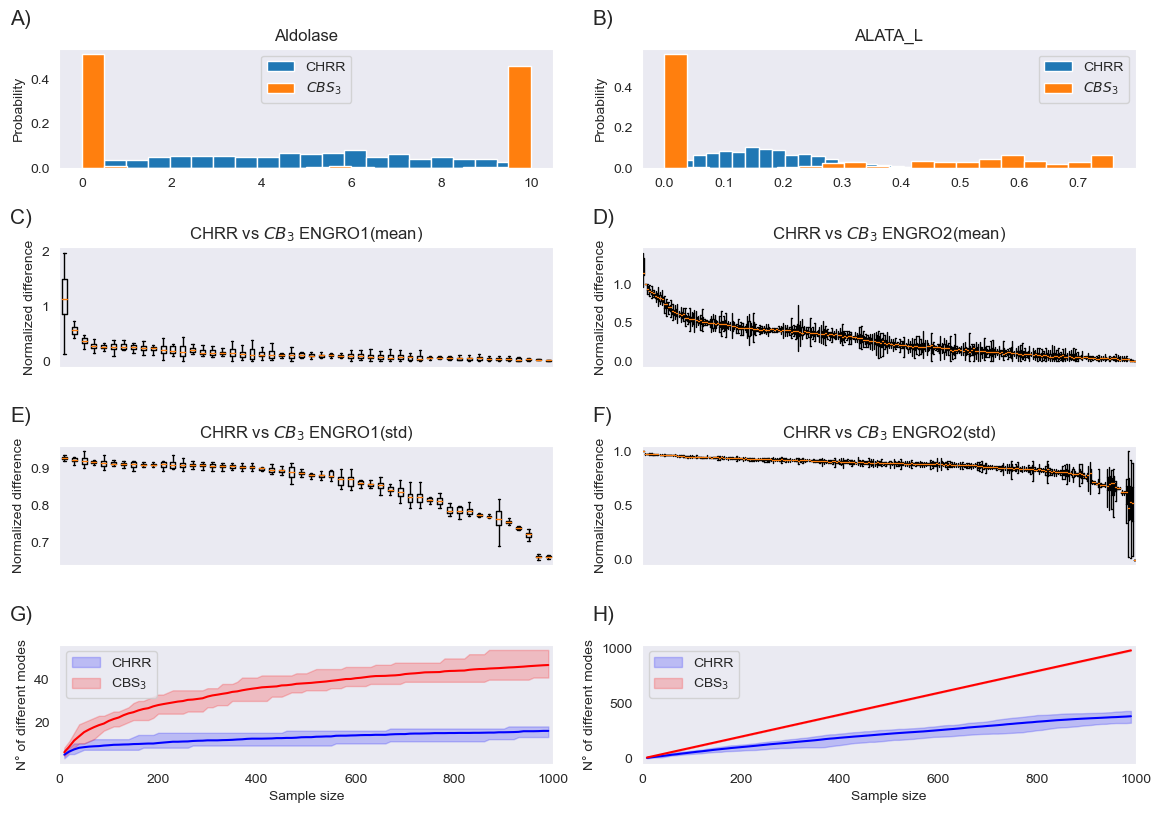

In [53]:
fig,ax=plt.subplots(4,2)
fig.set_size_inches(11.69,8.27)
from matplotlib.ticker import PercentFormatter


weights = np.ones_like(df1reaction) / len(df1reaction)
ax[0,0].hist(df1reaction,bins=20,weights=weights,label="CHRR");

weights = np.ones_like(df2reaction) / len(df2reaction)
ax[0,0].hist(df2reaction,bins=20,weights=weights,label="$CBS_3$");
ax[0,0].grid()
ax[0,0].set_ylabel("Probability")
ax[0,0].set_title("Aldolase")
ax[0,0].legend()

weights = np.ones_like(df1reaction2) / len(df1reaction2)
ax[0,1].hist(df1reaction2,bins=20,weights=weights,label="CHRR");
weights = np.ones_like(df2reaction2) / len(df2reaction2)
ax[0,1].hist(df2reaction2,bins=20,weights=weights,label="$CBS_3$");
ax[0,1].grid()
ax[0,1].set_ylabel("Probability")
ax[0,1].set_title("ALATA_L")
ax[0,1].legend()
#ax[0,1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax[1,0].boxplot(dfENGRO1mean,showfliers=False);
ax[1,0].set_ylabel("Normalized difference")
ax[1,0].set_title("CHRR vs $CB_3$ ENGRO1(mean)")

ax[1,0].tick_params(axis="x", rotation=90,labelsize=10,
                    bottom=False,  top=False, labelbottom=False)
ax[1,0].grid()


ax[1,1].boxplot(dfENGRO2mean,showfliers=False);
ax[1,1].set_ylabel("Normalized difference")
ax[1,1].set_title("CHRR vs $CB_3$ ENGRO2(mean)")
ax[1,1].tick_params(axis="x", rotation=90,labelsize=10,
                    bottom=False,  top=False, labelbottom=False)
ax[1,1].grid()


ax[2,0].boxplot(dfENGRO1var,showfliers=False);
ax[2,0].set_ylabel("Normalized difference")
ax[2,0].set_title("CHRR vs $CB_3$ ENGRO1(std)")

ax[2,0].tick_params(axis="x", rotation=90,labelsize=10,
                    bottom=False,  top=False, labelbottom=False)
ax[2,0].grid()


ax[2,1].boxplot(dfENGRO2var,showfliers=False);
ax[2,1].set_ylabel("Normalized difference")
ax[2,1].set_title("CHRR vs $CB_3$ ENGRO2(std)")
ax[2,1].tick_params(axis="x", rotation=90,labelsize=10,
                   bottom=False,  top=False, labelbottom=False)
ax[2,1].grid()


ax[3,0].fill_between([i*10 for i in range(1,100)], 
                 np.max(howmanybENGRO1total,axis=1),
                 np.min(howmanybENGRO1total,axis=1),
                 facecolor="blue", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2,label="CHRR")          # Trans

ax[3,0].plot([i*10 for i in range(1,100)], 
                 np.mean(howmanybENGRO1total,axis=1),'b')          # Trans

ax[3,0].fill_between([i*10 for i in range(1,100)], 
                 np.max(howmany2bENGRO1total,axis=1),
                 np.min(howmany2bENGRO1total,axis=1),
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,label="CBS$_{3}$")          # Trans

ax[3,0].plot([i*10 for i in range(1,100)], 
                 np.mean(howmany2bENGRO1total,axis=1),'r')          # Trans


ax[3,0].grid()
ax[3,0].set_ylabel("N° of different modes")
ax[3,0].set_xlabel("Sample size")
ax[3,0].set_xlim([0,1000])
ax[3,0].legend()

ax[3,1].fill_between([i*10 for i in range(1,100)], 
                 np.max(howmanybENGRO2total,axis=1),
                 np.min(howmanybENGRO2total,axis=1),
                 facecolor="blue", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2,label="CHRR")          # Trans

ax[3,1].plot([i*10 for i in range(1,100)], 
                 np.mean(howmanybENGRO2total,axis=1),'b')          # Trans


ax[3,1].fill_between([i*10 for i in range(1,100)], 
                 np.max(howmany2bENGRO2total,axis=1),
                 np.min(howmany2bENGRO2total,axis=1),
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.2,label="CBS$_{3}$")          # Trans

ax[3,1].plot([i*10 for i in range(1,100)], 
                 np.mean(howmany2bENGRO2total,axis=1),'r')          # Trans

ax[3,1].grid()
ax[3,1].set_ylabel("N° of different modes")
ax[3,1].set_xlabel("Sample size")
#ax[2,1].set_yscale("log")
ax[3,1].set_xlim([0,1000])
ax[3,1].legend()

ax[0,0].text(-0.1, 1.2, 'A)',fontdict={"fontsize":15},transform=ax[0,0].transAxes)
ax[0,1].text(-0.1, 1.2, 'B)',fontdict={"fontsize":15},transform=ax[0,1].transAxes)
ax[1,0].text(-0.1, 1.2, 'C)',fontdict={"fontsize":15},transform=ax[1,0].transAxes)
ax[1,1].text(-0.1, 1.2, 'D)',fontdict={"fontsize":15},transform=ax[1,1].transAxes)
ax[2,0].text(-0.1, 1.2,'E)',ha='left',fontdict={"fontsize":15},transform=ax[2,0].transAxes)
ax[2,1].text(-0.1, 1.2, 'F)',fontdict={"fontsize":15},transform=ax[2,1].transAxes)
ax[3,0].text(-0.1, 1.2,'G)',ha='left',fontdict={"fontsize":15},transform=ax[3,0].transAxes)
ax[3,1].text(-0.1, 1.2, 'H)',fontdict={"fontsize":15},transform=ax[3,1].transAxes)

plt.tight_layout()
plt.savefig("../../figures/Chrr_Cbs.png",dpi=600)